# Support Vector Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import hinge_loss, accuracy_score
from sklearn.svm import SVC

## Load and Preprocess the Dataset

In [2]:
iris = load_iris(as_frame=True)
selected_samples = iris.target > 0
X = iris.data[['petal length (cm)', 'petal width (cm)']][selected_samples].reset_index(drop=True)
y = iris.target[selected_samples].map({ 1: -1, 2: 1 }).reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Create the Model from Scratch

In [3]:
class SVCFromScratch:
    PLOT_X_LIM = [3, 7]
    PLOT_Y_LIM = [0, 4]
    CMAP = ListedColormap(['lightskyblue', 'bisque'])
    FIRST_TARGET_COLOR = 'tab:blue'
    SECOND_TARGET_COLOR = 'tab:orange'
    
    def __init__(self, C=1):
        self.C = C
        self.w1 = 1
        self.w2 = 1
        self.b = 0

    def get_linear(self, x1_param, x2_param):
        return x1_param * self.w1 + x2_param * self.w2 + self.b

    def is_violating_margin(self, x1_param, x2_param, y_param):
        return y_param * self.get_linear(x1_param, x2_param) < 1

    def get_objective_function_partial_derivative_wj(self, wj_param, xj_param, y_param):
        return wj_param - self.C * np.sum(y_param * xj_param)
    
    def get_objective_function_partial_derivative_b(self, y_param):
        return -self.C * np.sum(y_param)

    def run_one_epoch(self, lr, x1_param, x2_param, y_param):
        instance_indexes_violating_margin = self.is_violating_margin(x1_param, x2_param, y_param)
        x1_violating_margin = x1_param[instance_indexes_violating_margin]
        x2_violating_margin = x2_param[instance_indexes_violating_margin]
        y_violating_margin = y_param[instance_indexes_violating_margin]
        
        self.w1 -= lr * self.get_objective_function_partial_derivative_wj(
            self.w1, x1_violating_margin, y_violating_margin
        )
        self.w2 -= lr * self.get_objective_function_partial_derivative_wj(
            self.w2, x2_violating_margin, y_violating_margin
        )
        self.b -= lr * self.get_objective_function_partial_derivative_b(y_violating_margin)
    
    def predict(self, x_param):
        x1 = x_param.iloc[:, 0]
        x2 = x_param.iloc[:, 1]
        
        return np.where(self.get_linear(x1, x2) > 0, +1, -1)
    
    def get_predictions_mesh_grid(self):
        step = 0.1

        xx, yy = np.mgrid[
            self.PLOT_X_LIM[0]:self.PLOT_X_LIM[1]+step:step,
            self.PLOT_Y_LIM[0]:self.PLOT_Y_LIM[1]+step:step
        ]
        zz = np.array([
            [self.predict(pd.DataFrame([[xx[i, j], yy[i, j]]]))[0] 
             for j in range(xx.shape[1])]
            for i in range(xx.shape[0])
        ])

        return xx, yy, zz
    
    def get_line_coordinates(self):
        m = -(self.w1 / self.w2)
        c = -(self.b / self.w2)

        line_coordinates_x = np.arange(self.PLOT_X_LIM[0], self.PLOT_X_LIM[1] + 1, 0.1)
        line_coordinates_y = m * line_coordinates_x + c
        
        return line_coordinates_x, line_coordinates_y
    
    def get_hinge_loss(self, x1_param, x2_param, y_param, zeros):
        subject = 1 - y_param * self.get_linear(x1_param, x2_param)
        
        return np.sum(np.max(np.stack([zeros, subject], axis=1), axis=1))
    
    def animate(self, frame, ax, x1_param, x2_param, y_param, y_predicted_frames,
                line_coordinates_x_frames, line_coordinates_y_frames, hinge_loss_frames,
                predictions_mesh_grid_frames):
        xx, yy, zz = predictions_mesh_grid_frames[frame]

        is_correctly_classified = y_param == y_predicted_frames[frame]
        is_wrongly_classified = np.invert(is_correctly_classified)
        is_first_target = y_param == -1
        is_second_target = np.invert(is_first_target)

        cc_first_target_instance_indexes = is_correctly_classified & is_first_target
        cc_second_target_instance_indexes = is_correctly_classified & is_second_target
        wc_first_target_instance_indexes = is_wrongly_classified & is_first_target
        wc_second_target_instance_indexes = is_wrongly_classified & is_second_target

        ax.clear()
        ax.set_xlim(self.PLOT_X_LIM)
        ax.set_ylim(self.PLOT_Y_LIM)
        ax.axhline(0, color='black')
        ax.axvline(0, color='black')
        ax.pcolormesh(xx, yy, zz, cmap=self.CMAP)
        ax.scatter(x1_param[cc_first_target_instance_indexes],
                   x2_param[cc_first_target_instance_indexes], c=self.FIRST_TARGET_COLOR, 
                   edgecolors='black', label='Correctly Classified As Versicolor')
        ax.scatter(x1_param[cc_second_target_instance_indexes],
                   x2_param[cc_second_target_instance_indexes], c=self.SECOND_TARGET_COLOR,
                   edgecolors='black', label='Correctly Classified As Virginica')
        ax.scatter(x1_param[wc_second_target_instance_indexes], 
                   x2_param[wc_second_target_instance_indexes], c=self.FIRST_TARGET_COLOR, 
                   edgecolors='red', label='Wrongly Classified As Versicolor')
        ax.scatter(x1_param[wc_first_target_instance_indexes], 
                   x2_param[wc_first_target_instance_indexes], c=self.SECOND_TARGET_COLOR, 
                   edgecolors='red', label='Wrongly Classified As Virginica')
        ax.legend()
        ax.plot(line_coordinates_x_frames[frame], line_coordinates_y_frames[frame], color='red')
        ax.set_axisbelow(True)
        ax.grid(color='grey')
        ax.set_title(f"Epoch: {frame + 1} (HL={hinge_loss_frames[frame]:.5f})")
        ax.set_xlabel('petal length (cm)')
        ax.set_ylabel('petal width (cm)')
        ax.set_xticks(np.arange(self.PLOT_X_LIM[0], self.PLOT_X_LIM[1]))
        ax.set_yticks(np.arange(self.PLOT_Y_LIM[0], self.PLOT_Y_LIM[1]))
    
    def fit(self, x_param, y_param, lr=0.001, epochs=100, create_animation=False):
        if len(x_param.shape) != 2:
            raise Exception(("This support vector classifier implementation works only with "
                             "two-dimensional features!"))
        if len(y_param.unique()) != 2:
            raise Exception(("This support vector classifier implementation works only with "
                             "two target values!"))

        x1 = x_param.iloc[:, 0]
        x2 = x_param.iloc[:, 1]
        zeros = np.zeros(len(x_param))
        
        y_predicted_frames = []
        predictions_mesh_grid_frames = []
        line_coordinates_x_frames = []
        line_coordinates_y_frames = []
        hinge_loss_frames = []
        
        for epoch in range(epochs):
            self.run_one_epoch(lr, x1, x2, y_param)
            
            if create_animation:
                y_predicted = self.predict(x_param)
                predictions_mesh_grid = self.get_predictions_mesh_grid()
                line_coordinates_x, line_coordinates_y = self.get_line_coordinates()
                hl = self.get_hinge_loss(x1, x2, y_param, zeros)
                
                y_predicted_frames.append(y_predicted)
                predictions_mesh_grid_frames.append(predictions_mesh_grid)
                line_coordinates_x_frames.append(line_coordinates_x)
                line_coordinates_y_frames.append(line_coordinates_y)
                hinge_loss_frames.append(hl)
            
        if create_animation:
            fig, ax = plt.subplots(figsize=plt.figaspect(1.))
            animation = FuncAnimation(fig, self.animate, epochs, fargs=(
                ax, x1, x2, y_param, y_predicted_frames, line_coordinates_x_frames,
                line_coordinates_y_frames, hinge_loss_frames, predictions_mesh_grid_frames
            ))

            animation.save('support_vector_classification.gif', writer=PillowWriter(fps=15),
                           dpi=200)

## Create an Animation and Compare Implementations

Hinge Loss: 0.16
Accuracy Score: 0.92


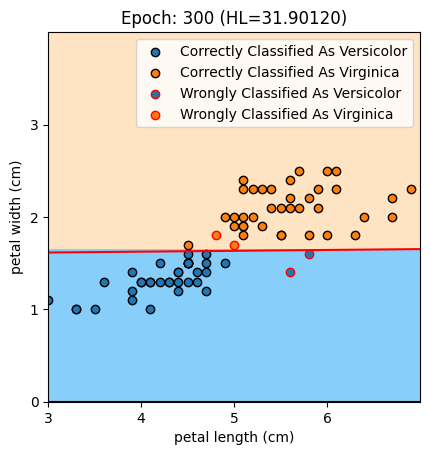

In [4]:
model_from_scratch = SVCFromScratch()

model_from_scratch.fit(X_train, y_train, epochs=300, create_animation=True)

y_pred = model_from_scratch.predict(X_test)

print(f"Hinge Loss: {hinge_loss(y_test, y_pred)}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

In [5]:
model = SVC()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Hinge Loss: {hinge_loss(y_test, y_pred)}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

Hinge Loss: 0.32
Accuracy Score: 0.84
